In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

sns.set()  # Using seaborn style

# Whisky Flavor Clustering

This table contains 86 whiskies with flavor ratings in 12 categories. This notebook performs some clustering on those 12-dimensional flavor profiles and looks for distinct categories of whisky. 

In [2]:
url = 'https://raw.githubusercontent.com/sweis/whiskies/master/whiskies.txt'
df = pd.read_csv(url).drop(columns=['RowID','Postcode'])
df.head()

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Latitude,Longitude
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,286580,749680
1,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,326340,842570
2,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,352960,839320
3,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,141560,646220
4,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,355350,829140


This will scale each flavor's score from a range of 0-4 to a 0-1 range, then perform a principal component analysis (PCA). This produces as 12-dimensional coordinate ordered by how much each coordinate explains the variance in the data. That is, the 1st degree is the most significant in determining the flavors of each whisky. 

In [15]:
train = df.drop(columns=['Distillery', 'Longitude', 'Latitude'])
scaler = MinMaxScaler().fit(train)
X = scaler.transform(train)
pca = PCA().fit(X)
Z = pca.transform(X)

Just for illustration, here is a plot of the top 2 coordinates in the PCA. The X and Y coordinates are some linear comibinations of flavors.

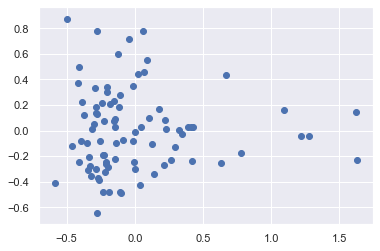

In [16]:
plt.scatter(Z[:,0], Z[:,1])

This will cluster 12-dimensional flavor coordinates Affinity Propagation. We're looking to find similar clusters of whiskies.

In [17]:
ap = AffinityPropagation().fit(Z)

In [18]:
def plot(labels, names, x, y):
  unique_labels = np.unique(labels)
  unique_dict = dict(zip(range(0, len(unique_labels)), unique_labels))
  fig, ax = plt.subplots(figsize=(20,12))
  ax.set_ylim(530000, 1050000)
  ax.set_xlim(100000, 420000)
  cmap = cm.get_cmap('tab20b')
  palette = list(map(cmap, [(x/(unique_labels.max()+1)) for x in range(0, unique_labels.max()+1)]))
  colors = [palette[x] for x in labels]
  ax.scatter(x, y, c=colors, marker='.')  
  for i, txt in enumerate(names):
    plt.text(x[i], y[i], txt, ha='left', va='center', c=colors[i])

This plots flavor clusters by color with geographic location. One interesting observation is that the flavor clusters are not that coorelated with traditional whisky regions.

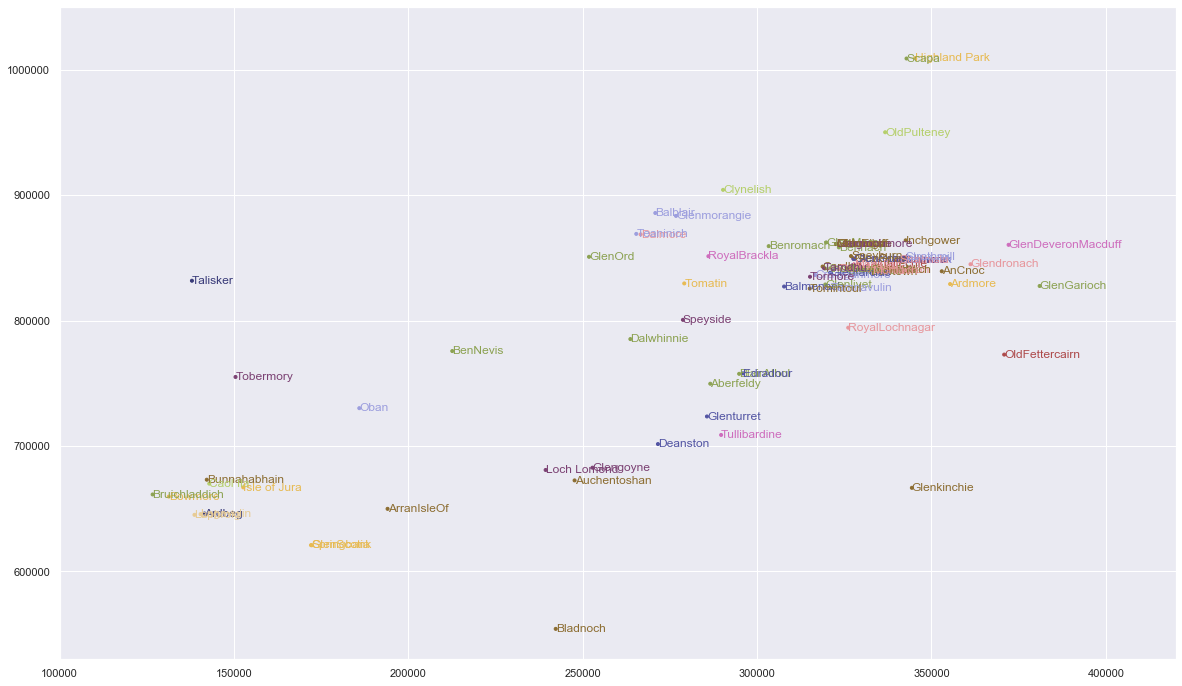

In [19]:
plot(ap.labels_, df['Distillery'], df['Latitude'], df['Longitude'])

In [20]:
def make_radar_chart(ax, name, mean, std, attribute_labels, plot_markers, color):
    labels = np.array(attribute_labels)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    mean = np.concatenate((mean,[mean[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    ax.plot(angles, mean, 'o-', alpha=1, linewidth=1, c=color)
    std = np.concatenate((std,[std[0]]))
    ax.fill_between(angles, np.subtract(mean, std), np.add(mean, std), alpha=0.3, color=color)
    ax.set_yticks([])
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(name, c=color, loc='center', pad=25)
    ax.grid(True)

In [21]:
data = df.drop(columns=['Latitude', 'Longitude'])
unique_labels = np.unique(ap.labels_)
cmap = cm.get_cmap('tab20b')
palette = list(map(cmap, [(x/(unique_labels.max()+1)) for x in range(0, unique_labels.max()+1)]))
colors = [palette[x] for x in unique_labels]
labels = data.columns[1:]
markers = ["Low", "", "", "", "High"]
representatives = ['Talisker', 
                   'Edradour', 
                   'Oban', 
                   'Glenlivet', 
                   'Caol Ila', 
                   'Glenfiddich', 
                   'Isle of Jura', 
                   'Lagavulin', 
                   'Craigallechie',
                   'Macallan', 
                   'Loch Lomond',
                   'Tullibardine']

The below is a plot of each cluster's flavor profile. The line is the mean score for each member of that cluster, while the shaded area is the standard deviation. One representative whisky is shown for each group. We can see that, for example, Group 1 (including Talisker) is medicinal, smoky, with body. Group 8 is a similar flavor profile, though we can quickly see they differ in spiciness. By contrast, Group 6 is much more sweet and floral and has little medicinal or smoky flavor. 

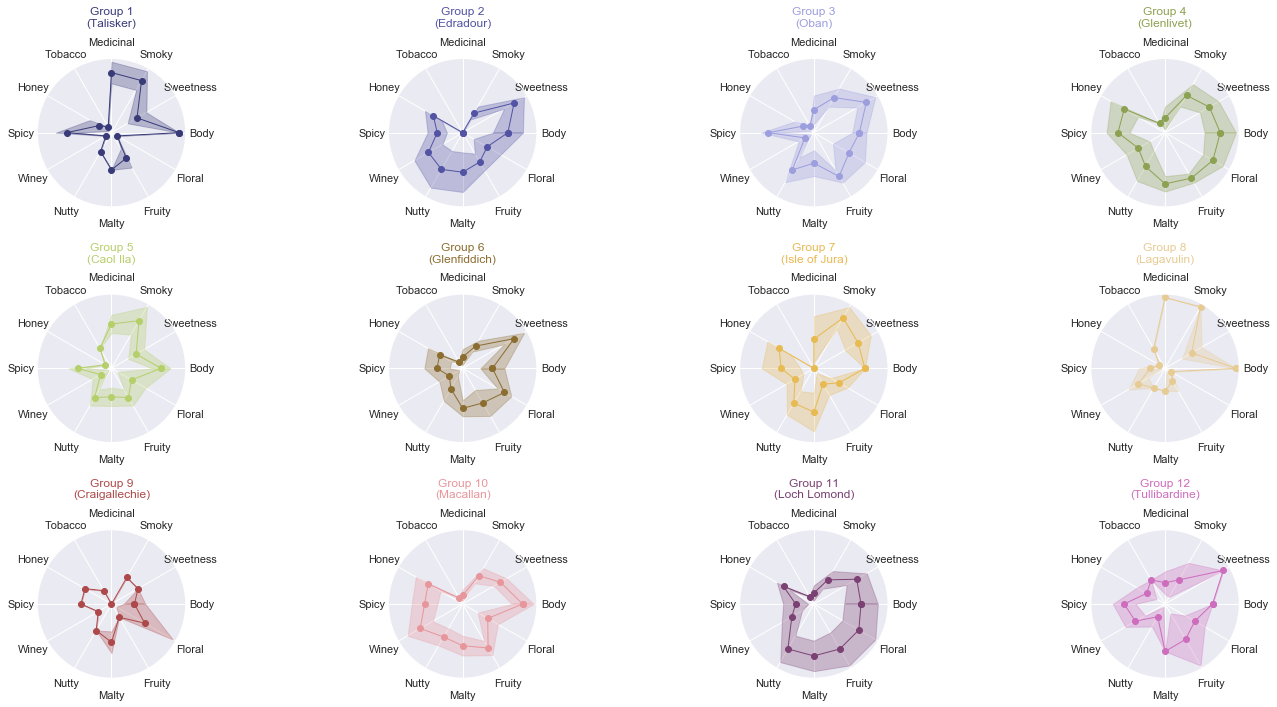

In [23]:
fig, axes = plt.subplots(3, 4, subplot_kw=dict(polar=True), figsize=(20,10), sharey=False, tight_layout=True)
for i in unique_labels:
    cluster = df[i == ap.labels_].drop(columns=['Latitude', 'Longitude'])
    desc = cluster.describe()
    mean = desc.T['mean'].values
    std = desc.T['std'].values
    row = int(i / 4)
    col = int(i % 4)
    make_radar_chart(axes[row][col], "Group {}\n({})".format(i+1,representatives[i], len(cluster)), mean, std, labels, markers, colors[i])

The above is a plot of each cluster's flavor profile. The dotted line is the mean score for each member of that cluster, while the shaded area is the standard deviation. One representative whisky is shown for each group.

In [24]:
mins = [np.min(Z[:,0]), np.min(Z[:,1]), np.min(Z[:,2]), np.min(Z[:,3])]
maxes = [np.max(Z[:,0]), np.max(Z[:,1]), np.max(Z[:,2]), np.max(Z[:,3])]
vs = [[]] * 8
for i in range(0, 4):
    vs[2*i] = [ 0 ] * 12
    vs[2*i][i] = mins[i]
    vs[2*i+1] = [ 0 ] * 12
    vs[2*i+1][i] = maxes[i]

extremes = scaler.inverse_transform(pca.inverse_transform(vs))
ext_df = pd.DataFrame(extremes, columns = train.columns)
ext_df.round(0).head()

unique_labels = np.unique(ap.labels_)
labels = data.columns[1:]
markers = ["Low", "", "", "", "High"]
np_labels = np.array(labels)
angles = np.linspace(0, 2*np.pi, len(np_labels), endpoint=False)
angles = np.concatenate((angles,[angles[0]]))

The below chart attempts to explain what the PCA dimensions actually measure. The percentage on the top shows how much that PCA dimension explains the variance of all the data. PCA Dimension 1 accounts for 28% of variance in this example.

Each plot shows the minimum and maximum values in that dimension with all other coordinates fixed at zero. The solid line represents the maximum value while the shaded area represents the range between the maximum and minimum. For example, the first plot shows the range between [max_0, 0, ..., 0] and [min_0, 0, ..., 0]. The second shows [0, max_1, 0, ..., 0] and [0, min_1, 0, ..., 0], etc.

From this visualization, we can see that the most important dimension is an axis between Medicinal & Smokiness versus Floral & Fruitiness. The second most distinct axis is how much Body, Honey, Spice, andNutty flavor there is. 

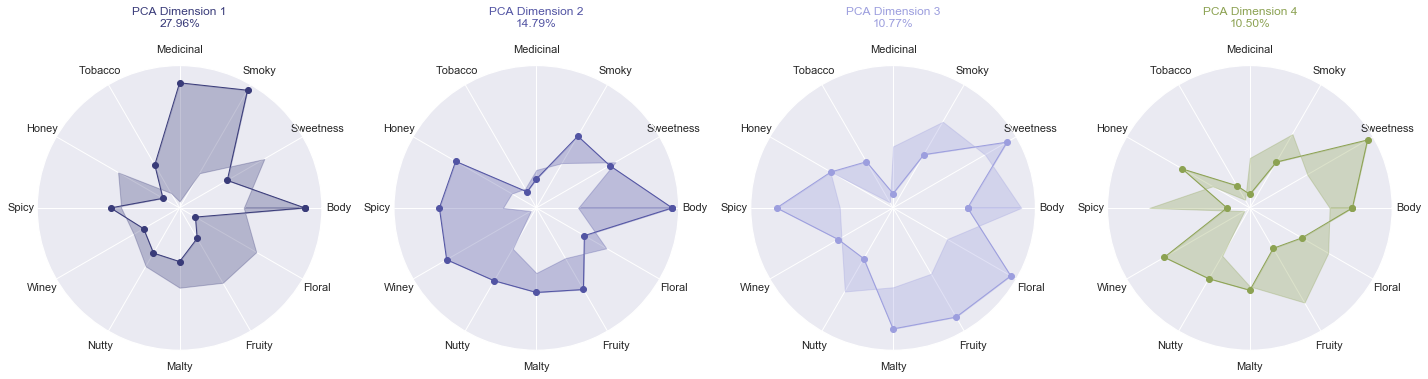

In [25]:
fig, axes = plt.subplots(1, 4, subplot_kw=dict(polar=True), figsize=(20,10), sharey=False, tight_layout=True)
for i in range(4):
    col = i % 4
    min_d = ext_df.iloc[2*i]
    max_d = ext_df.iloc[2*i+1]
    max_d = np.concatenate((max_d,[max_d[0]]))
    min_d = np.concatenate((min_d,[min_d[0]]))
    ax = axes[i]
    ax.plot(angles, max_d, 'o-', alpha=1, linewidth=1, c=colors[i])
    ax.fill_between(angles, min_d, max_d, alpha=0.3, color=colors[i])
    ax.set_yticks([])
    ax.set_thetagrids(angles * 180/np.pi, np_labels)
    ax.set_title("PCA Dimension {}\n{:.2f}%".format(i+1, 100*pca.explained_variance_ratio_[i]), c=colors[i], loc='center', pad=25)
    ax.grid(True)